# Newton's kissing spheres and simulated annealing

Newton asked whether it was possible to stack 13 spheres of unit
radius $R=1$ around a fixed central sphere of radius 1. The 13 spheres must be in contact with the central one but have no overlap
between them. Another way to
phrase the same question is to ask what can be the maximum
radius $R$ for 13 spheres stacked around the central one
(that is always of unit radius). This is the question we will try to answer numerically. We will use two approaches:

- Direct sampling
- Simulated annealing

Let us import the relevant libraries here. There is a bit more this time because we will do some 3D graphics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
from mpl_toolkits.mplot3d import Axes3D

## Direct sampling

The central sphere on which we will be depositing our 13 spheres is of radius 1. We place it at the origin. The 13 spheres have radius R. Because they are in contact with the central sphere, the centers of the 13 spheres are all at a distance $1+R$ from the origin.




- What is the condition that the centers of the 13 spheres need
to satisfy to ensure that there is no overlap?

There will be no overlap if the distance between all the centers is always larger than $2R$.

- Write a program that tries to find a configuration for 13 spheres of radius $R$ so that they have no overlap. Start with a small
value for $R = 0.4$. Then, use direct sampling in order to
generate a random set of 13 vectors of norm $1+R$ indicating the positions of the centers of the 13 spheres. To do so, start by generating three Gaussian distributed $(x,y,z)$ and then normalize the vector so that it has length $1+R$. Generate 13 such points and then check whether there are overlaps. Proceed like this until you generate a legal configuration. Keep track of the number of attempts that are needed. Then, increase $R$ slowly and observe how the number of attempts increases. Is this a good strategy?

  _Hint_: the function `scipy.spatial.distance_matrix(v1, v2)` computes all pair-wise distances between two lists of points `v1` and `v2`.

In [2]:
points = np.random.normal(size=(10,3))
#points / np.linalg.norm(points, axis=1)[:,None]
print(points.shape)
print(np.triu_indices(3,1))

(10, 3)
(array([0, 0, 1]), array([1, 2, 2]))


In [3]:
#Osservation:
points = np.random.normal(size=(10,3))
print(np.shape(points))
print(np.shape(points[:,None]))
print(np.shape(points[None,:]))

(10, 3)
(10, 1, 3)
(1, 10, 3)


In [4]:
def generate_points(n, radius):
    """Returns an array of n points on a sphere of given radius"""
    points = np.random.normal(size=(n, 3)) #we are in three dimensions
    points *= radius / np.linalg.norm(points, axis=1)[:,None] #axis=1 we do the norm row by row
    # [:,None] is to add a dimension, look at the example at previous cell
    return points

def smallest_distance(points):
    """Finds the smallest distance between two points"""
    
    # number of points
    n = points.shape[0]
    
    # use scipy: compute all relative distances
    dmatrix = scipy.spatial.distance_matrix(points, points)
    
    # isolate the upper triangular part of the matrix
    dists = dmatrix[np.triu_indices(n, k=1)]
    
    return np.min(dists)

In [5]:
N = 13
R = 0.3

# try to find a set of non-overlapping spheres
n_attempts = 0
while(True):
    
    # generate points and check smallest distance
    n_attempts += 1
    centers = generate_points(N, 1+R)
    min_dist = smallest_distance(centers)
    
    if (min_dist > 2*R): break
        
print("It took ", n_attempts, "attempts")

It took  17 attempts


In [6]:
N = 13

R_range= np.linspace(0.4, 0.5, 20)
attempts=[]
for R in R_range:
    n_attempts = 0
    while(True):
        
        # generate points and check smallest distance
        n_attempts += 1
        centers = generate_points(N, 1+R)
        min_dist = smallest_distance(centers)
        
        if (min_dist > 2*R): break
    attempts.append(n_attempts)



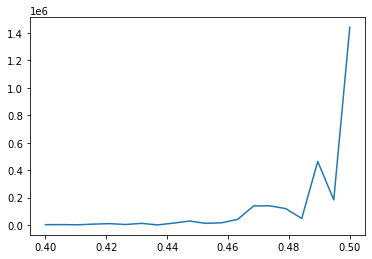

In [7]:
plt.plot(R_range, attempts)

## Plotting the spheres

It can be nice to create a figure with all the spheres. The code below defines the function `draw_all_spheres` which
will do that.

In [8]:
def draw_single_sphere(ax, origin, radius, nmesh, color='c'):

    phi, theta = np.mgrid[0.0:np.pi:nmesh*1j, 0.0:2.0*np.pi:nmesh*1j]
    x = origin[0] + radius * np.sin(phi) * np.cos(theta)
    y = origin[1] + radius * np.sin(phi) * np.sin(theta)
    z = origin[2] + radius * np.cos(phi)

    ax.plot_surface(x, y, z,  rstride=1, cstride=1, \
                    color=color, alpha=0.7, linewidth=0)

def draw_all_spheres(centers, radius, nmesh=20):

    # create 3d figure
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    # central sphere
    draw_single_sphere(ax, [0,0,0], 1.0, nmesh)

    # other spheres
    for center in centers:
        draw_single_sphere(ax, center, radius, nmesh, 'r')

    # cosmetics
    L = 1+R
    ax.set_xlim([-L,L])
    ax.set_ylim([-L,L])
    ax.set_zlim([-L,L])
    ax.set_aspect("auto")
    ax.set_axis_off()
    ax.set_title("Newton spheres", fontsize=20)
    plt.show()

- Make a plot of the configuration that has been found above

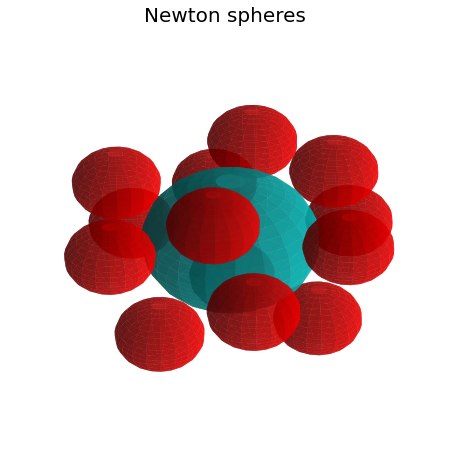

In [9]:
draw_all_spheres(centers, R)

## Simulated annealing

The direct sampling approach very quickly becomes
problematic. A much more efficient strategy is to use simulated annealing. The idea is to run a Markov chain algorithm that samples allowed sphere configurations while slowly increasing the radius of the spheres. The procedure ends when it is no longer possible to increase the radii.

More precisely, the algorithm goes as follows:

1. Start with a small radius, say $R=0.4$ and generate a first legal configuration. You already wrote the code for that.

2. Move the spheres around by shifting their positions randomly. Use a Gaussian distribution of width $\sigma$ to generate the displacement vectors. Only accept moves that generate allowed configurations. Keep track of how many moves are accepted and rejected. (acceptance ratio 04-0.6)

3. After a certain number $N_\mathrm{thumb}$ of moves, estimate the acceptance ratio for the moves from the ratio between the number accepted moves and the total number of moves $N_\mathrm{thumb}$. You can take $N_\mathrm{thumb}$ between 100 and 1000.

4. Try to have an acceptance rate close to the thumb rule. Anything between 0.4 and 0.6 will be fine. If your acceptance rate is not in this interval, adjust the width $\sigma$ of the Gaussian distribution. You can multiply or divide $\sigma$ by 2 to produce a new acceptance rate.

5. When the acceptance rate is fine, increase the radius $R$ of the spheres. There is a maximum value $R_\mathrm{max}$ for the radius that will still avoid overlaps between the spheres. It is however not a good idea to increase $R$ directly to $R_\mathrm{max}$. This has a tendency to create jammed configurations. Rather pick a new value of $R \to R + \gamma (R_\mathrm{max}-R)$. You can take $\gamma = 0.15$.

6. Proceed to point 2 with the new value of $R$. You can stop the procedure after a certain number of steps.

In general, annealing simulations can get jammed in a local minimum. For this particular problem, however, annealing works very well.

- Implement the annealing algorithm described above. Make sure you keep track of the value of $R$ during the simulation. You can also compute the density of packing of the spherical caps on top of the central sphere:

$$
\rho=\frac{N}{2} \left(1-\sqrt{1-r^2}\right) \qquad \text{with} \qquad r = \frac{1}{1 + 1/R}
$$

In [10]:
# returns the acceptance rate
def move_points(points, sigma, R, n_thumb):
    
    N = points.shape[0]
    
    accepted = 0
    for i in range(n_thumb):

        # pick a random sphere and backup the point
        k = np.random.randint(N)
        point = points[k].copy()

        # small modification of the position
        delta = np.random.normal(0, sigma, size=3)
        points[k] += delta
        points[k] *= (1+R) / np.linalg.norm(points[k])

        # new minimum distance
        min_dist = np.sort(np.linalg.norm(points[k] - points, axis=1))[1]
        if min_dist > 2*R:
            accepted += 1
        else:
            points[k] = point

    # adjust sigma for thumb rule
    return accepted / n_thumb

In [11]:
%%time
# starting parameters
N = 13
R = 0.4

# find a legal initial configuration
while(True):
    pts = generate_points(N, 1+R)
    min_dist = smallest_distance(pts)    
    if (min_dist > 2*R): break #accept first allowed configuration.

# simulation parameters
n_steps = 2000
sigma  = 1.0
gamma = 0.15
n_thumb = 100

# arrays with results
radius = np.zeros(n_steps)
density = np.zeros(n_steps)

# main annealing loop
for step in range(n_steps):

    # loop to move points around and adjust sigma
    while(True):
        rate = move_points(pts, sigma, R, n_thumb)
        if rate < 0.4:
            sigma *= 0.5
        elif rate > 0.6:
            sigma *= 2.0
        else: break
        
    # increase radius of the spheres
    min_dist = smallest_distance(pts)
    R += gamma * (0.5*min_dist - R)
    
    # compute the density
    r = 1 / (1 + 1/R)
    rho = 0.5 * N * (1 - np.sqrt(1 - r**2))

    # store data
    radius[step] = R
    density[step] = rho
    
    #print("Step = ", step, R, sigma, rate)

CPU times: user 7.96 s, sys: 146 ms, total: 8.1 s
Wall time: 7.7 s


- Print the final radius and final density. Plot the final configuration of spheres.

Final radius =  0.9103580008423537
Final density =  0.7854994852956936


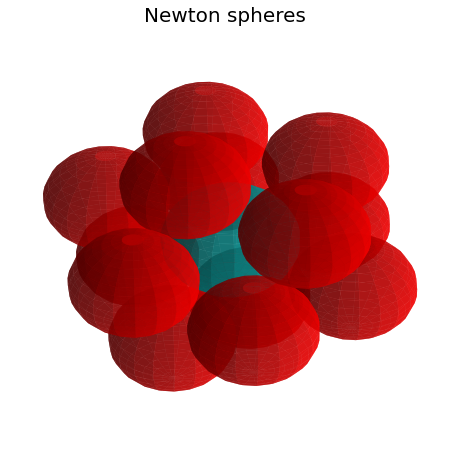

In [12]:
print("Final radius = ", radius[-1])
print("Final density = ", density[-1])

draw_all_spheres(pts, R)

- Plot the evolution of the radius and of the density as a function of simulation steps. See how things
  change if you take different values for $\gamma$.

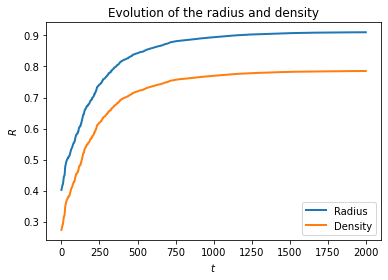

In [13]:
plt.plot(radius, lw=2, label="Radius")
plt.plot(density, lw=2, label="Density")

plt.title("Evolution of the radius and density")
plt.xlabel("$t$")
plt.ylabel("$R$")
plt.legend()